In [118]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [119]:
import pandas
from google.colab import files
uploaded = files.upload()

Saving movie_actor_network.csv to movie_actor_network (4).csv


In [120]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [121]:
edges = [tuple(x) for x in data.values.tolist()]

In [122]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [123]:
A = list(nx.connected_component_subgraphs(B))[0]

In [124]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


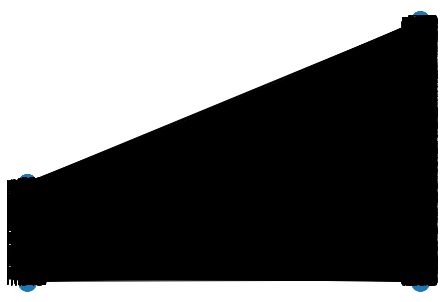

In [125]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [126]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [127]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [128]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [129]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [130]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [131]:
print(node_embeddings.shape)

(4703, 128)


In [132]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    
    for idx,i in enumerate(node_ids):
      if ('m' in i):
        movie_embeddings.append(node_embeddings[idx])
        movie_nodes.append(i)
      if 'a' in i:
        actor_embeddings.append(node_embeddings[idx])
        actor_nodes.append(i)
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [133]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

In [134]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

In [135]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

In [136]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    maxConnectedComponent = max(nx.connected_component_subgraphs(graph), key=len)
    numNodesInMaxComponent=maxConnectedComponent.number_of_nodes()
    totalNodes=graph.number_of_nodes()
    cost1=((1/number_of_clusters)*(numNodesInMaxComponent/totalNodes))
    return cost1

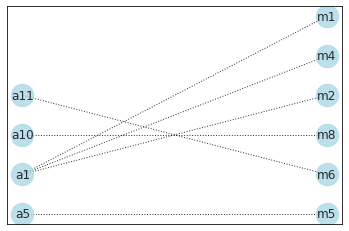

In [137]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [138]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [139]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    cost2=0
    degree = graph.degree()
    sumDegreeOfActor = 0
    movieNode = 0
    for i in degree:
      if 'a' in i[0]:
        sumDegreeOfActor+=i[1]
      else:
        movieNode+=1 
    cost2 = ((1/number_of_clusters)*(sumDegreeOfActor/movieNode))
    return cost2

In [140]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

**Grouping Similar Actors**

In [141]:
from sklearn.cluster import KMeans

In [142]:
costForEachClusterActor = {}

for cluster in [3,5,10,50,200,300]:
  currentCost1=0
  currentCost2=0
  kmeansAlgo = KMeans(n_clusters=cluster)
  kmeansAlgo.fit(actor_embeddings)
  labels = kmeansAlgo.labels_
  for i in range(cluster):  #for each cluster making grapha
    G = nx.Graph()
    filterLabel=[]
    indexForNodesInEachCluster = [index for index,value in enumerate(labels) if value == i]
    nodesInCluster = [actor_nodes[k] for k in indexForNodesInEachCluster]
    for node in nodesInCluster:
      subGraph = nx.ego_graph(B,node)
      G.add_nodes_from(subGraph.nodes)
      G.add_edges_from(subGraph.edges())
    preCost1 = cost1(G,cluster)
    currentCost1 = currentCost1+preCost1
    preCost2 = cost2(G,cluster)
    currentCost2=currentCost2+preCost2
  costForCurrentCluster = currentCost1 * currentCost2
  costForEachClusterActor[cluster]= costForCurrentCluster


In [143]:
optimalNumberOfCluster= max(costForEachClusterActor, key=costForEachClusterActor.get) 
print("Optimal Number Of Cluster = ",optimalNumberOfCluster)

Optimal Number Of Cluster =  3


In [144]:
optimalModel = KMeans(n_clusters = optimalNumberOfCluster)
optimalModel.fit(actor_embeddings)


KMeans(n_clusters=3)

In [145]:
labels = optimalModel.labels_

In [146]:
nodeNumberDictionary = {}

for i in range(optimalNumberOfCluster):
  indexOfNodes = [index for index,value in enumerate(labels) if value ==i]
  node = [actor_nodes[k] for k in indexOfNodes]
  for n in node :
    nodeNumberDictionary[n]=i

In [147]:
print(nodeNumberDictionary)

{'a973': 0, 'a967': 0, 'a964': 0, 'a1731': 0, 'a970': 0, 'a1057': 0, 'a969': 0, 'a1028': 0, 'a965': 0, 'a1003': 0, 'a959': 0, 'a966': 0, 'a988': 0, 'a1037': 0, 'a962': 0, 'a49': 0, 'a93': 0, 'a971': 0, 'a963': 0, 'a1030': 0, 'a960': 0, 'a1027': 0, 'a204': 0, 'a977': 0, 'a1016': 0, 'a472': 0, 'a968': 0, 'a1004': 0, 'a1020': 0, 'a1026': 0, 'a1035': 0, 'a138': 0, 'a975': 0, 'a972': 0, 'a306': 0, 'a1036': 0, 'a1031': 0, 'a987': 0, 'a1008': 0, 'a205': 0, 'a1467': 0, 'a1038': 0, 'a1021': 0, 'a976': 0, 'a1015': 0, 'a974': 0, 'a1011': 0, 'a782': 0, 'a1750': 0, 'a1060': 0, 'a228': 0, 'a1005': 0, 'a1023': 0, 'a1018': 0, 'a1029': 0, 'a1025': 0, 'a1024': 0, 'a1032': 0, 'a1039': 0, 'a1019': 0, 'a1043': 0, 'a989': 0, 'a1063': 0, 'a1716': 0, 'a1047': 0, 'a1034': 0, 'a1048': 0, 'a1045': 0, 'a1033': 0, 'a1076': 1, 'a768': 1, 'a631': 1, 'a407': 1, 'a1507': 1, 'a1435': 1, 'a1436': 1, 'a921': 1, 'a363': 1, 'a893': 1, 'a3378': 1, 'a393': 1, 'a3369': 1, 'a1381': 1, 'a595': 1, 'a773': 1, 'a812': 1, 'a1366': 

**Displaying Similar Actors in different Clusters**

In [148]:
from sklearn.manifold import TSNE
tsneModel = TSNE 
transformObject = tsneModel(n_components=2)
actor_embeddings_2d = transformObject.fit_transform(actor_embeddings)

Text(0.5, 1.0, 'TSNE 2D visualization of actor embeddings')

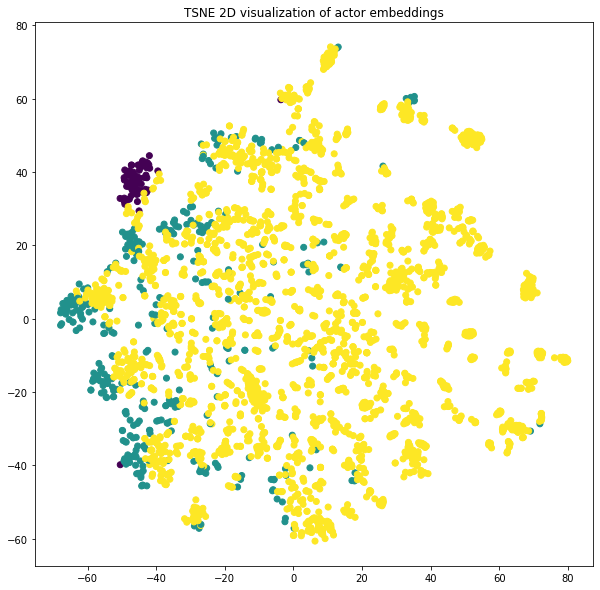

In [149]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(actor_embeddings_2d[:,0], actor_embeddings_2d[:,1], c=optimalModel.labels_.astype(float))
plt.title('TSNE 2D visualization of actor embeddings')

**Grouping Similar Movies**

In [150]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    cost2=0
    degree = graph.degree()
    sumDegreeOfMovie = 0
    actorNode = 0
    for i in degree:
      if 'm' in i[0]:
        sumDegreeOfMovie+=i[1]
      else:
        actorNode+=1 
    cost2 = ((1/number_of_clusters)*(sumDegreeOfMovie/actorNode))
    return cost2

In [151]:
from sklearn.cluster import KMeans

In [152]:
costForEachClusterMovie = {}

for cluster in [3,5,10,50,200,300]:
  currentCost1=0
  currentCost2=0
  kmeansAlgo = KMeans(n_clusters=cluster)
  kmeansAlgo.fit(movie_embeddings)
  labels = kmeansAlgo.labels_
  for i in range(cluster):  #for each cluster making grapha
    G = nx.Graph()
    filterLabel=[]
    indexForNodesInEachCluster = [index for index,value in enumerate(labels) if value == i]
    nodesInCluster = [actor_nodes[k] for k in indexForNodesInEachCluster]
    for node in nodesInCluster:
      subGraph = nx.ego_graph(B,node)
      G.add_nodes_from(subGraph.nodes)
      G.add_edges_from(subGraph.edges())
    preCost1 = cost1(G,cluster)
    currentCost1 = currentCost1+preCost1
    preCost2 = cost2(G,cluster)
    currentCost2=currentCost2+preCost2
  costForCurrentCluster = currentCost1 * currentCost2
  costForEachClusterMovie[cluster]= costForCurrentCluster


In [153]:
optimalNumberOfCluster= max(costForEachClusterMovie, key=costForEachClusterMovie.get) 
print("Optimal Number Of Cluster = ",optimalNumberOfCluster)

Optimal Number Of Cluster =  200


In [154]:
optimalModel = KMeans(n_clusters = optimalNumberOfCluster)
optimalModel.fit(movie_embeddings)


KMeans(n_clusters=200)

In [155]:
labels = optimalModel.labels_

In [156]:
nodeNumberDictionary = {}

for i in range(optimalNumberOfCluster):
  indexOfNodes = [index for index,value in enumerate(labels) if value ==i]
  node = [actor_nodes[k] for k in indexOfNodes]
  for n in node :
    nodeNumberDictionary[n]=i

**Displaying Similar Movies**

In [157]:
from sklearn.manifold import TSNE
tsneModel= TSNE #PCA
transformObject = transform(n_components=2)
movie_embeddings_2d = transformObject.fit_transform(movie_embeddings)

Text(0.5, 1.0, 'TSNE 2D visualization of actor embeddings')

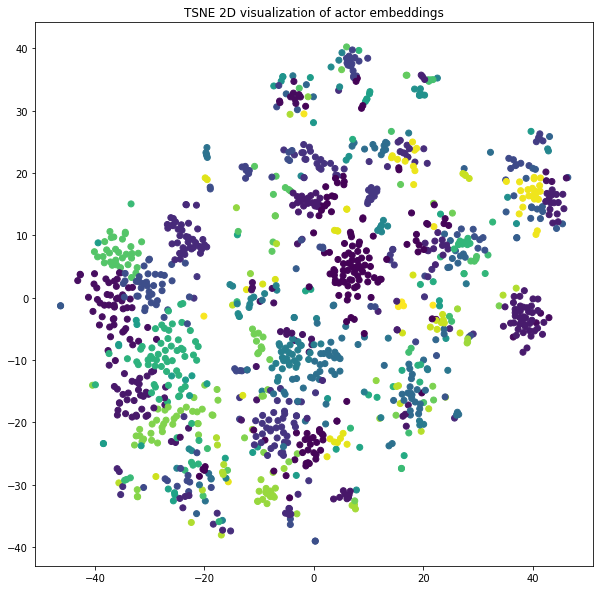

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(movie_embeddings_2d[:,0], movie_embeddings_2d[:,1], c=optimalModel.labels_.astype(float))
plt.title('TSNE 2D visualization of actor embeddings')